In [1]:
import time
from math import sqrt
import matplotlib.pyplot as plt
import random
import env_sim_complete_params2
import env6
import os
import numpy as np
import torch
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from copy import deepcopy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
plt.ioff()

In [2]:
class ExperienceDataset(Dataset):
    def __init__(self, data):
        super().__init__()
        self.data = data

    def __len__(self):
        return len(self.data[0])

    def __getitem__(self, ind):
        return tuple(map(lambda t: t[ind], self.data))

def create_shuffled_dataloader(data, batch_size):
    ds = ExperienceDataset(data)
    return DataLoader(ds, batch_size = batch_size, shuffle = True)

In [3]:
class PolicyNetwork(torch.nn.Module):
    def __init__(self,state_dims, n_actions):
        super(PolicyNetwork, self).__init__()
        self.actor = torch.nn.Sequential(
            torch.nn.Linear(state_dims, 64),
            torch.nn.Tanh(),
            torch.nn.Linear(64, 32),
            torch.nn.Tanh(),
            torch.nn.Linear(32, n_actions),
            torch.nn.Softmax(dim=-1)
        )

    def forward(self, x):
        policy = self.actor(x)
        return policy
    

class ValueNetwork(torch.nn.Module):
    def __init__(self,state_dims):
        super(ValueNetwork, self).__init__()
        self.critic = torch.nn.Sequential(
            torch.nn.Linear(state_dims, 64),
            torch.nn.Tanh(),
            torch.nn.Linear(64, 32),
            torch.nn.Tanh(),
            torch.nn.Linear(32, 1)
        )

    def forward(self, x):
        value = self.critic(x)
        return value
        
def weights_init(m):
    if isinstance(m,torch.nn.Linear):
        m.bias.data.fill_(0)
        torch.nn.init.kaiming_uniform_(m.weight)

def np_to_tensor(x):
    return torch.tensor(x).to(torch.float32)

    
policy_model = PolicyNetwork(state_dims=10, n_actions = 10)
value_model = ValueNetwork(state_dims=10)

In [4]:
# print(policy_model,value_model)
summary(policy_model, input_size=(1, 10))
summary(value_model, input_size=(1, 10))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 64]             704
              Tanh-2                [-1, 1, 64]               0
            Linear-3                [-1, 1, 32]           2,080
              Tanh-4                [-1, 1, 32]               0
            Linear-5                [-1, 1, 10]             330
           Softmax-6                [-1, 1, 10]               0
Total params: 3,114
Trainable params: 3,114
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 6

In [12]:
class PPO:
    def __init__(self, state_dim=6, action_dim=6, policy_lr=0.0005, value_lr=0.001, 
                 gamma=0.99, lam=0.95, beta_s=0.01,epsilon_clip=0.2, value_clip=0.4, 
                 epochs=5,batch_size=50,save_path='Models',env=None):
        
        self.policy_net = PolicyNetwork(state_dim, action_dim).to(device)
        self.value_net = ValueNetwork(state_dim).to(device)
        self.policy_net.apply(weights_init)
        self.value_net.apply(weights_init)

        self.policy_optimizer = torch.optim.Adam(self.policy_net.parameters(), lr=policy_lr)
        self.value_optimizer = torch.optim.Adam(self.value_net.parameters(), lr=value_lr)

        self.gamma = gamma
        self.lamda = lam
        self.epsilon_clip = epsilon_clip
        self.value_clip = value_clip
        self.beta_s = beta_s
        self.epochs = epochs
        self.action_dim = action_dim
        self.batch_size = batch_size

        self.env = env
        self.env.run()

        self.save_path = save_path
        self.env_name = "auto-docking-iss"

        if not os.path.exists(self.save_path): os.makedirs(self.save_path)
        self.path = str(self.env_name)+'_PPO_'
        self.model_name = os.path.join(self.save_path, self.path)

        self.trajectory = {'states':[],'actions':[], 'rewards':[], 'action_logs':[],
                           'values':[],'done':[]}
        
        self.scores, self.episodes, self.average = [],[],[]
        self.value_loss_mean, self.policy_loss_mean = [], []
        self.rewards,self.average_reward = [],[]

    def save(self,episode,score):
        torch.save({
            'actor': self.policy_net.state_dict(),
            'critic': self.value_net.state_dict()
        }, f'./'+ self.model_name + '_' + str(episode) + '_' + str(round(score,4)) + '.pt')

    def load(self,name):
        print(f'./{name}')
        try:
            data = torch.load(f'./{name}',weights_only=True)
            self.policy_net.load_state_dict(data['actor'])
            self.value_net.load_state_dict(data['critic'])
        except Exception as e:
            print(e)

    # Función para visualizar la evolución del entrenamiento
    def plot_model(self, score, episode,num_episodes):
        self.scores.append(score)
        self.episodes.append(episode)
        self.average.append(sum(self.scores[-10:]) / len(self.scores[-10:]))
        if (episode % 10 == 0 and episode > 0) or episode == num_episodes:#str(episode)[-2:] == "00":# much faster than episode % 100
            plt.figure(1,figsize=(10, 5))
            plt.plot(self.episodes, self.scores, 'b')
            plt.plot(self.episodes, self.average, 'r')
            plt.ylabel('Score', fontsize=12)
            plt.xlabel('Steps', fontsize=12)
            try:
                plt.savefig(self.model_name+"scores.png")
            except OSError:
                pass

        return self.average[-1]

    def plot_reward(self,reward,episode,num_episodes):
        self.rewards.append(reward)
        self.average_reward.append(sum(self.rewards[-10:]) / len(self.rewards[-10:]))     
        if (episode % 10 == 0 and episode > 0) or episode == num_episodes:#str(episode)[-2:] == "00":# much faster than episode % 100
            plt.figure(2,figsize=(10, 5))
            plt.plot(self.episodes, self.rewards, 'b')
            plt.plot(self.episodes, self.average_reward, 'r')
            plt.ylabel('Reward', fontsize=12)
            plt.xlabel('Steps', fontsize=12)
            try:
                plt.savefig(self.model_name+"last-state-reward.png")
            except OSError:
                pass

    
    def plot_loss(self,episode,num_episodes):        
        if (episode % 10 == 0 and episode > 0) or episode == num_episodes:#str(episode)[-2:] == "00":# much faster than episode % 100
            plt.figure(3,figsize=(10, 5))
            plt.plot(self.episodes, self.policy_loss_mean, 'b')
            plt.plot(self.episodes, self.value_loss_mean, 'r')
            plt.ylabel('Loss', fontsize=12)
            plt.xlabel('Steps', fontsize=12)
            try:
                plt.savefig(self.model_name+"loss.png")
            except OSError:
                pass
    
    def save_data_to_file(self,data,file):
        with open(self.model_name+file, 'a') as archivo:
            archivo.write(data)

    #Almacenamiento de todas las variables que definen una transición para PPO
    def collect_trayectory(self,state,action,action_logs,reward,done,value):
        self.trajectory['states'].append(state)
        self.trajectory['actions'].append(action)
        self.trajectory['rewards'].append(reward)
        self.trajectory['values'].append(value)
        self.trajectory['action_logs'].append(action_logs)
        self.trajectory['done'].append(done)
    
    def clear_trayectory(self):
        for key in self.trajectory.keys():
            self.trajectory[key].clear()
    
    def select_action(self,state):
        action_probs = self.policy_net(state).squeeze().detach()
        dist = torch.distributions.Categorical(action_probs)
        action = dist.sample()
        action_log_probs = dist.log_prob(action)
        
        return action.item(),action_log_probs,dist.entropy().item()

    
    def generalized_advantage_estimation(self,next_state):
        advantages = np.zeros_like(self.trajectory['rewards'])
        last_gae_lambda = 0
        self.trajectory['values'].append(self.value_net(next_state).squeeze().detach())

        for t in reversed(range(len(self.trajectory['rewards']))):
            delta = self.trajectory['rewards'][t]+ self.gamma * self.trajectory['values'][t + 1].item() - self.trajectory['values'][t].item()
            advantages[t] = last_gae_lambda = delta + self.gamma * self.lamda * last_gae_lambda
        
        return np_to_tensor(advantages)


    def learn_from_episode_trajectory(self,next_state):
        self.policy_net.train()
        self.value_net.train()

        states = deepcopy(self.trajectory['states'])
        actions = deepcopy(self.trajectory['actions'])
        # rewards = deepcopy(self.trajectory['rewards'])
        values = deepcopy(self.trajectory['values'])
        action_logs = deepcopy(self.trajectory['action_logs'])
        # done = deepcopy(self.trajectory['done'])

        advantages = self.generalized_advantage_estimation(next_state).to(device)

        # prepare dataloader for policy phase training
        dl = create_shuffled_dataloader([states, actions, action_logs, advantages, values], self.batch_size)

        policy_loss_array = []
        value_loss_array = []

        for i in range(self.epochs):
            for states, actions, action_log, advantages, values in dl:
                #Update policy_net
                new_action_probs = self.policy_net(states).squeeze()
                dist = torch.distributions.Categorical(new_action_probs)

                new_action_logs = dist.log_prob(actions)
                entropy = dist.entropy()

                # compute PPO-Clip
                ratios = torch.exp(new_action_logs - action_log)
                surr1 = ratios * advantages
                surr2 = ratios.clamp(1 - self.epsilon_clip, 1 + self.epsilon_clip) * advantages
                policy_loss = -torch.mean(torch.min(surr1, surr2) - self.beta_s * entropy)
                policy_loss_array.append(policy_loss.detach().numpy())

                self.policy_optimizer.zero_grad() # Clean gradients
                policy_loss.mean().backward() # Compute gradients
                self.policy_optimizer.step() #Update weights

                #Update value_net
                new_values = self.value_net(states).squeeze()
                value_clipped = values + (new_values - values).clamp(-self.value_clip, self.value_clip)
                value_loss_1 = (value_clipped.flatten() - advantages) ** 2
                value_loss_2 = (values.flatten() - advantages) ** 2
                value_loss = torch.mean(torch.max(value_loss_1, value_loss_2))
                value_loss_array.append(value_loss.detach().numpy())

                self.value_optimizer.zero_grad() # Clean gradients
                value_loss.backward() # Compute gradients 
                self.value_optimizer.step() #Update weights

        self.value_loss_mean.append(sum(value_loss_array)/self.epochs)
        self.policy_loss_mean.append(sum(policy_loss_array)/self.epochs)

        # print(f"\n Mean Policy loss: {self.value_loss_mean[-1]:.4f}. Mean Value loss: {self.policy_loss_mean[-1]:.4f}")
        
        self.policy_net.eval()
        self.value_net.eval()


    # Función para resetear el entorno tras acabar trayectoria
    def reset(self):
        state = self.env.reset()
        return np_to_tensor(self.process_state(state))
    
     # Función para interacción agente-entorno
    def step(self, action,step,max_steps):
        next_state, reward, done = self.env.step(action,step,max_steps)
        next_state = self.process_state(next_state)
        return np_to_tensor(next_state), reward, done

    def process_state(self,state):
        state_processed = np.array(state[1:3]+state[4:])
        state_processed[0] = state_processed[0] / 1.0 # y
        state_processed[1] = state_processed[1] / 1.0 # z
        state_processed[4] = state_processed[4] / 1.0 # roll
        state_processed[5] = state_processed[5] / 1.0 # pith
        state_processed[6] = state_processed[6] / 1.0 # yaw
        return state_processed
    
    def train(self,init_episode=1,num_episodes=200,max_steps=200,dt=0.01):
        average = 0
        self.policy_net.eval()
        self.value_net.eval()

        max_score_average = 1000

        num_episodes += init_episode

        for episode in range(init_episode,num_episodes):
            self.clear_trayectory()

            state = self.reset()
            score = 0

            SAVING = ""

            for step in range(1,max_steps+1):
                action_probs = self.policy_net(state).squeeze().detach()
                dist = torch.distributions.Categorical(action_probs)
                action = dist.sample()
                action_log = dist.log_prob(action)

                value = self.value_net(state).squeeze().detach()
                
                next_state,reward,done = self.step(action.item()+2,step,max_steps)    
                self.collect_trayectory(state,action,action_log,reward,done,value)

                state = next_state

                score += reward

                # print(state)
                # print(f'\rSteps: {step}/{max_steps}. Action: {action}. Reward/Value: {round(reward,2)}/{round(value.item(),4)}. Done: {done}', end='', flush=True)

                if done:
                    break
                
                # time.sleep(dt)

            self.learn_from_episode_trajectory(next_state)
            self.clear_trayectory()

            average = self.plot_model(score, episode,num_episodes)
            self.plot_loss(episode,num_episodes)
            #self.plot_reward(reward,episode,num_episodes)
            
            if episode > 40 and average >= max_score_average:
                max_score_average = average
                self.save(episode,reward)
                SAVING = "SAVING"
            # elif episode % 10 == 0:
            #     self.save(episode,average)
            #     SAVING = "SAVING"
            else:
                SAVING = ""
            
            # print(f"\rEpisode: {episode}/{num_episodes-1}. Steps: {step}/{max_steps}. Score/Average/reward: {score:.2f}/{average:.2f}/{reward:.2f} {SAVING}      ", end='', flush=True)
            s_print =  np.around(self.env.state[1:3]+self.env.state[6:9],4).tolist()
            print(f"\rEpisode: {episode}/{num_episodes-1}. Steps: {step}/{max_steps}. Score/Average: {score:.2f}/{average:.2f}. Done: {done}.\t State: {s_print}      ", end='', flush=True)

            self.save_data_to_file(file='train.txt',data=f"Episode: {episode}/{num_episodes-1}. Steps: {step}/{max_steps}. Score/Average: {score:.2f}/{average:.2f}. Done: {done}.\t State: {s_print}\n")


        # close environemnt when finish training
        self.save(episode,average)

    def test(self,max_steps):
        self.policy_net.eval()
        self.value_net.eval()

        self.clear_trayectory()
        state = self.reset()
        score = 0

        # y,z,roll,pitch,yaw = [],[],[],[],[]

        for step in range(1,max_steps+1):
            action_probabilities = self.policy_net(state)
            action = torch.argmax(action_probabilities, dim=-1).item()

            next_state,reward,done = self.step(action+2,step,max_steps) 

            # y.append(self.env.state[1])
            # z.append(self.env.state[2])
            # roll.append(self.env.state[6])
            # pitch.append(self.env.state[7])
            # yaw.append(self.env.state[8])
            
            state = next_state
            score += reward

            if done:
                break

            #time.sleep(dt)
        # plt.figure(4,figsize=(10, 5))
        # plt.plot([x for x in range(len(y))], y, 'b')
        # plt.plot([x for x in range(len(z))], z, 'r')
        # plt.plot([x for x in range(len(z))], roll, 'g')
        # plt.plot([x for x in range(len(z))], pitch, 'y')
        # plt.plot([x for x in range(len(z))], yaw, 'k')
        # plt.ylabel('Errors', fontsize=12)
        # plt.xlabel('Steps', fontsize=12)
        
        print(f'\rSteps: {step}/{max_steps}. Score/reward: {score:.2f}/{reward:.2f}. Done: {done}       ', end='', flush=True)

        return done

Episode: 205/400. Steps: 2500/2500. Score/Average: -10222.84/-7699.76. Done: -1. State: [-24.269, 5.5297, 20.5876, -21.641, 28.0847]         

KeyboardInterrupt: 

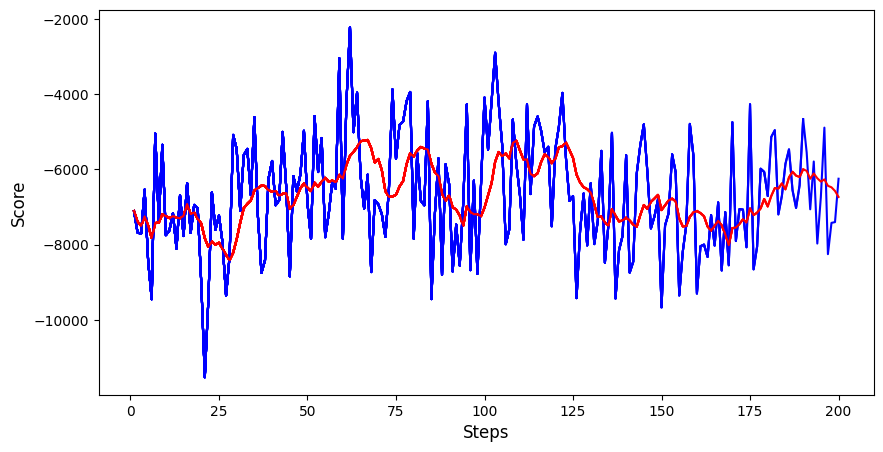

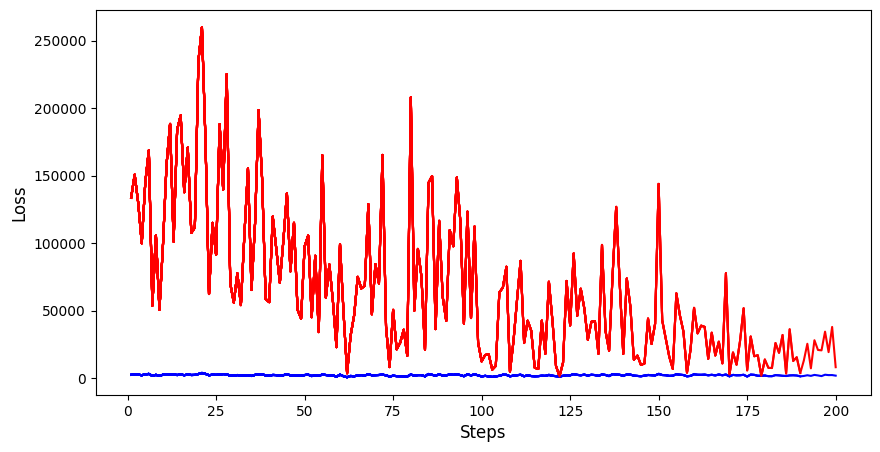

In [6]:
# Experiment 1 - No terminal reward
dt = 0.2
max_steps = 500
max_state = [30.0,10.0,10.0,10.0,10.0,10.0]
objective_state = [0.2,0.2,0.2,0.2,0.2,0.2]
range_state = [[15,20],6.0,6.0,6.0,6.0,6.0]
reward_terminal = [-0.0,0.0]
env = env_sim_complete_params2.Env(
    max_state=max_state,
    objective_state=objective_state,
    range_state=range_state,
    reward_terminal=reward_terminal,
    dt=dt)
agent = PPO(save_path='Models/Models16-4/Exp1',env=env,state_dim=10, action_dim=10)
agent.train(init_episode=1,num_episodes=400,max_steps=int(max_steps/dt))

Episode: 400/400. Steps: 2500/2500. Score/Average: 7423.76/7673.28. Done: 1. State: [0.0359, -0.0022, 0.0275, -0.0474, 0.0287]               

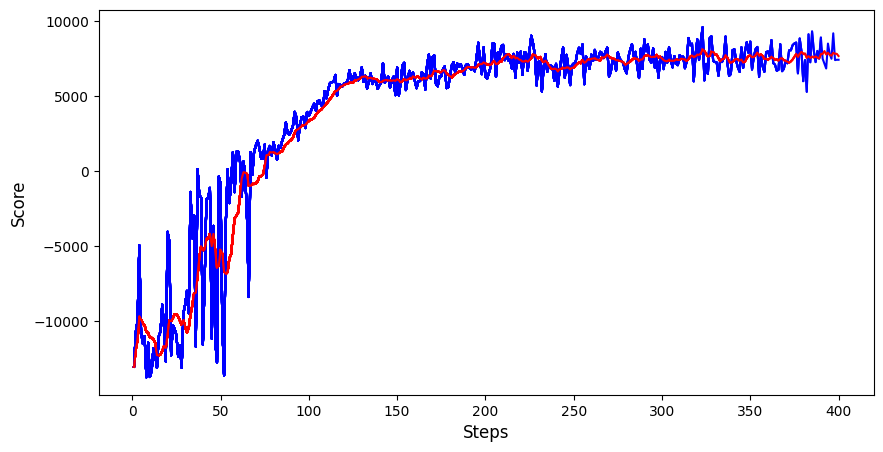

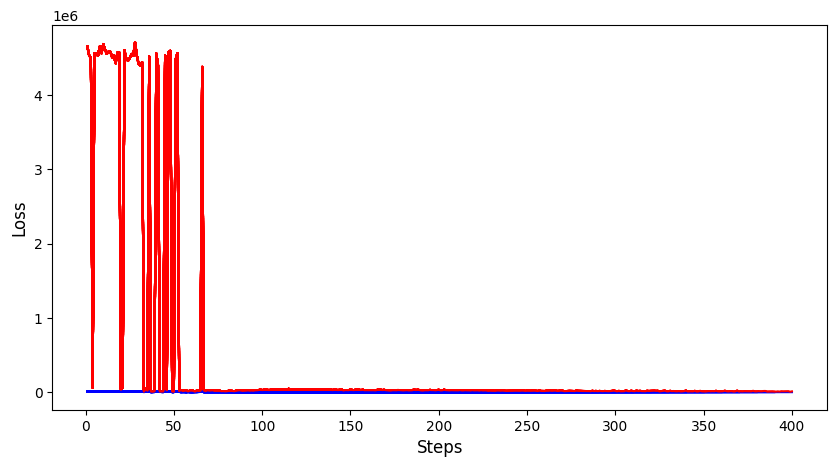

In [7]:
# Experiment 2 - Terminal reward neg
dt = 0.2
max_steps = 500
max_state = [30.0,10.0,10.0,10.0,10.0,10.0]
objective_state = [0.2,0.2,0.2,0.2,0.2,0.2]
range_state = [[15,20],6.0,6.0,6.0,6.0,6.0]
reward_terminal = [-5000.0,0.0]
env = env_sim_complete_params2.Env(
    max_state=max_state,
    objective_state=objective_state,
    range_state=range_state,
    reward_terminal=reward_terminal,
    dt=dt)
agent = PPO(save_path='Models/Models16-4/Exp2',env=env,state_dim=10, action_dim=10)
agent.train(init_episode=1,num_episodes=400,max_steps=int(max_steps/dt))

In [13]:
# Experiment 2 - Test
dt = 0.2
max_steps = 500
max_state = [30.0,10.0,10.0,10.0,10.0,10.0]
objective_state = [0.2,0.2,0.2,0.2,0.2,0.2]
range_state = [[15,20],6.0,6.0,6.0,6.0,6.0]
reward_terminal = [-5000.0,0.0]
env = env_sim_complete_params2.Env(
    max_state=max_state,
    objective_state=objective_state,
    range_state=range_state,
    reward_terminal=reward_terminal,
    dt=dt)
agent = PPO(save_path='Models/Models16-4/Exp2',env=env,state_dim=10, action_dim=10)
agent.load("Models/Models16-4/Exp2/auto-docking-iss_PPO__323_4.0998.pt")

./Models/Models16-4/Exp2/auto-docking-iss_PPO__323_4.0998.pt


In [15]:
done = []
for x in range(100):
    done.append(agent.test(int(max_steps/dt)))

ocurrencias = dict((i, done.count(i)) for i in done)
print("\n",ocurrencias)


Steps: 2500/2500. Score/reward: 6442.76/3.93. Done: 1       
 {1: 100}


Episode: 400/400. Steps: 2500/2500. Score/Average: 10735.77/10528.91. Done: 1.	 State: [-0.0386, -0.0303, -0.0895, 0.0279, -0.0904]             

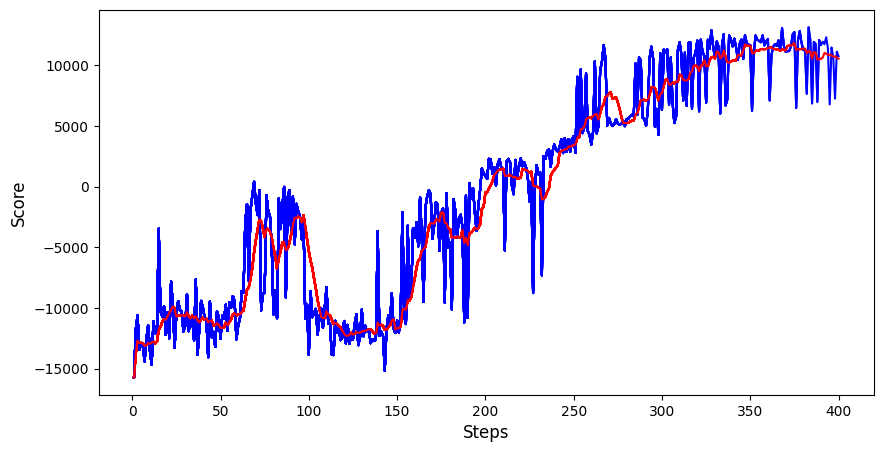

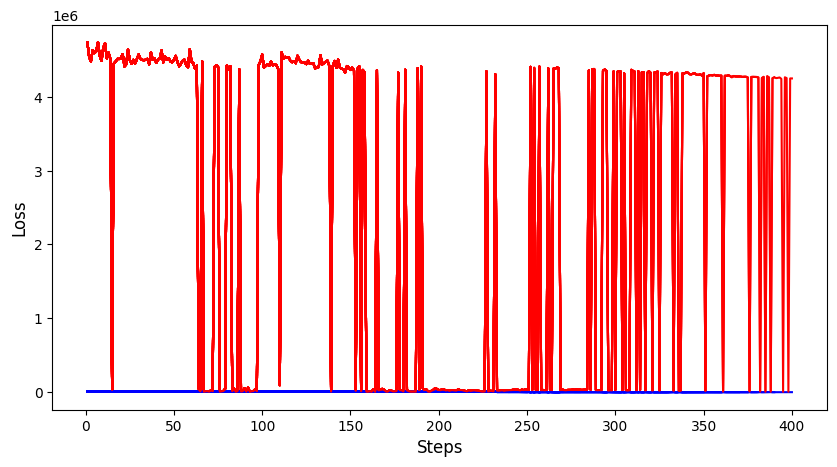

In [6]:
# Experiment 3 - Terminal neg and pos reward
dt = 0.2
max_steps = 500
max_state = [30.0,10.0,10.0,10.0,10.0,10.0]
objective_state = [0.2,0.2,0.2,0.2,0.2,0.2]
range_state = [[15,20],6.0,6.0,6.0,6.0,6.0]
reward_terminal = [-5000.0,5000.0]
env = env_sim_complete_params2.Env(
    max_state=max_state,
    objective_state=objective_state,
    range_state=range_state,
    reward_terminal=reward_terminal,
    dt=dt)
agent = PPO(save_path='Models/Models16-4/Exp3',env=env,state_dim=10, action_dim=10)
agent.train(init_episode=1,num_episodes=400,max_steps=int(max_steps/dt))

Episode: 769/800. Steps: 2500/2500. Score/Average: 5480.49/7751.52. Done: 0.	 State: [-0.0653, 0.0289, 0.2221, 0.0036, -0.1829]         

KeyboardInterrupt: 

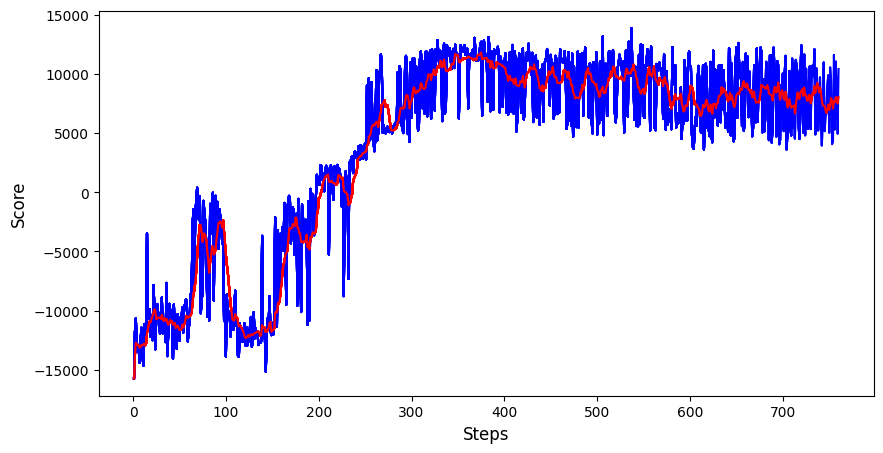

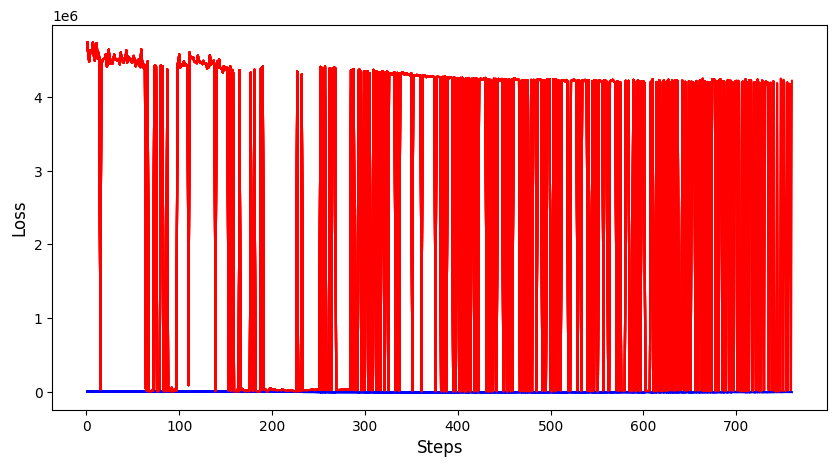

In [8]:
agent.train(init_episode=601,num_episodes=200,max_steps=int(max_steps/dt))

In [17]:
# Experiment 3 - Test
dt = 0.2
max_steps = 500
max_state = [30.0,10.0,10.0,10.0,10.0,10.0]
objective_state = [0.2,0.2,0.2,0.2,0.2,0.2]
range_state = [[15,20],6.0,6.0,6.0,6.0,6.0]
reward_terminal = [-5000.0,5000.0]
env = env_sim_complete_params2.Env(
    max_state=max_state,
    objective_state=objective_state,
    range_state=range_state,
    reward_terminal=reward_terminal,
    dt=dt)
agent = PPO(save_path='Models/Models16-4/Exp3',env=env,state_dim=10, action_dim=10)
agent.load("Models/Models16-4/Exp3/auto-docking-iss_PPO__375_5003.8768.pt")

done = []
for x in range(100):
    done.append(agent.test(int(max_steps/dt)))

ocurrencias = dict((i, done.count(i)) for i in done)
print("\n",ocurrencias)

./Models/Models16-4/Exp3/auto-docking-iss_PPO__375_5003.8768.pt
Steps: 2500/2500. Score/reward: 4535.41/3.66. Done: 0           
 {1: 76, 0: 24}
